In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from functools import partial
import matplotlib.pyplot as plt
import datareader.cleaner.lemas as cl
import simnet.similarity
import simnet.variety
from diffusion.simple_diff import get_diffusion_diff
from model_selection.stepwise import BackwardStepwise

from tqdm import tqdm
%load_ext line_profiler

In [2]:
## Get the attribute data for agencies
INDEX_COL = "ORI9"
df, cat_cols, con_cols = cl.lemas_df_cols("Imputed_Lemas.csv")
df = df[~(df['ORI9']==' ')]

all_nodes = df[INDEX_COL]

## Define the similarity metric
cosine_sim_8 = simnet.similarity.CosineSimilarity(0.8)
cosine_sim_7 = simnet.similarity.CosineSimilarity(0.7)

## Get the entropy-filtered columns
cat_col_variety_full = {col: v
                   for col in cat_cols if (v:=simnet.variety.get_discrete_variety_score(df[col]))}
variety_p75 = np.percentile(list(cat_col_variety_full.values()), 50)
cat_col_variety_75 = [col for col, v in cat_col_variety_full.items() if v > variety_p75]
cols_to_include = cat_col_variety_75 + ["log_pop", "log_budget"]


In [3]:
df.set_index("ORI9")

,Unnamed: 0,LEAR_ID,AGENCYNAME,CITY,ZIPCODE,STATE,COUNTY,FIPS,POPSERVED,POPGROUP,...,ISSU_ADDR_SCH,ISSU_ADDR_SWAT,ISSU_ADDR_TERROR,ISSU_ADDR_VIC,FINALWGT,NEW_TOT_HIRES,NEW_TOT_SEP,FINALWGT_NTH_NTS,log_pop,log_budget
ORI9,,,,,,,,,,,,,,,,,,,,,
CA0570100,0,635592,DAVIS POLICE DEPARTMENT,DAVIS,95618,CA,YOLO,6113,68111,5,...,3,2,3,2,7.185185,5.703704,3.629630,7.533981,0.660713,0.783248
NJ0091200,1,645110,WEST NEW YORK POLICE,WEST NEW YORK,7093,NJ,HUDSON,34017,53343,5,...,3,2,2,3,1.131206,31.629433,26.578014,1.183673,0.546056,0.674355
WV0310400,2,631270,WESTOVER POLICE DEPARTMENT,WESTOVER,26501,WV,MONONGALIA,54061,4243,8,...,5,5,5,5,7.304746,1.027363,0.634328,7.607534,-0.641567,-0.694089
WI0570200,3,631316,BARABOO POLICE DEPARTMENT,BARABOO,53913,WI,SAUK,55111,12173,7,...,1,2,3,3,6.913793,3.047414,2.344828,7.225225,-0.147114,-0.001664
WI0137400,4,631684,OREGON POLICE DEPARTMENT,OREGON,53575,WI,DANE,55025,3334,8,...,2,5,5,3,6.978166,1.711790,1.235808,7.347126,-0.754676,-0.207605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NV0020100,2779,645361,LAS VEGAS METRO POLICE DEPARTMENT,LAS VEGAS,89106,NV,CLARK,32003,1592178,1,...,4,1,1,2,1.131206,354.000000,216.000000,1.183673,2.139320,2.334349
CA0190000,2780,635749,LOS ANGELES COUNTY SHERIFF'S DEPARTMENT,MONTEREY PARK,91754,CA,LOS ANGELES,6037,10137915,1,...,2,1,1,2,1.321033,460.000000,1694.000000,1.415020,3.007789,3.131008
ILCPD0000,2781,638583,CHICAGO POLICE DEPARTMENT,CHICAGO,60653,IL,COOK,17031,2704958,1,...,2,1,1,2,1.131206,595.000000,506.000000,1.183673,2.387959,2.763773


In [4]:
## Get the State dynamic
nibrs_df = pd.read_parquet("DATA/map_plot.pq")

## Filter those that are within the attribute data
dynamic = nibrs_df[nibrs_df["ORI"].isin(all_nodes)].assign(y = nibrs_df["NUMBER OF MONTHS REPORTED"]>0) \
    .pivot_table(index="ORI", columns="year", values="y", aggfunc='first').fillna(False)
dynamic

year,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
ORI,,,,,,,,,,,,,,,,,,,,,
AK0010100,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AK0010300,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AK0011600,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
AK0015600,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
AL0010000,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY0150100,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
WY0190000,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
WY0210000,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True


In [5]:
common_agencies = sorted(set(dynamic.index) & set(df["ORI9"]))
df= df.set_index("ORI9").loc[common_agencies]

In [6]:
list(df.index) == list(dynamic.index)

True

In [7]:
cols_to_include.index('AGENCYTYPE')

116

## Test code change section

|Gen | Time| Improvement|
|-----|----|----------|
| 1 | 226ms| None |
|2 | 176ms| `njit` on diffusion diff|

Avgerage 11 sec per loop once joblib parallel

In [8]:
sn = simnet.similarity.SimilarityNetwork(
                df,
                cosine_sim_8,
                cols_to_include
            )
sn.fit_transform()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
def prof_function():
    sn = simnet.similarity.SimilarityNetwork(
                df,
                cosine_sim_8,
                cols_to_include
            )
    W = sn.fit_transform()


    # ## Any way to improve performance?
    # G = sn.network.subgraph(dynamic.index)

    # W = np.matrix(nx.adjacency_matrix(G, dynamic.index).toarray())
    diff = get_diffusion_diff(
        W,
        dynamic.to_numpy(dtype=np.float_),
        0.5
    )
    return diff

In [32]:
def prof_function():
    self_df = df[cols_to_include]
    selfindex_columns = df.index
    self_df = pd.get_dummies(self_df)
    selffeature_n = len(self_df.columns)

In [11]:
%%timeit
prof_function()

205 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%lprun -f prof_function prof_function()

Timer unit: 1e-07 s

Total time: 0.252283 s
File: C:\Users\tedb0\AppData\Local\Temp\ipykernel_24204\1689228538.py
Function: prof_function at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def prof_function():
     2         2    1019770.0 509885.0     40.4      sn = simnet.similarity.SimilarityNetwork(
     3         1          5.0      5.0      0.0                  df,
     4         1          3.0      3.0      0.0                  cosine_sim_8,
     5         1          6.0      6.0      0.0                  cols_to_include
     6                                                       )
     7         1    1252570.0    1e+06     49.6      W = sn.fit_transform()
     8                                           
     9                                           
    10                                               # ## Any way to improve performance?
    11                                               # G = sn.net

In [15]:
prof_function()

3121

In [8]:
import joblib
from joblib import delayed

removal_dict:dict[str, int] = {}
logging:list[dict[str, int]] = []
cols_to_include_for_removal = cols_to_include.copy()

dynamic_np = dynamic.to_numpy(dtype=np.float_)

# Define a function that performs the computation for a single category
def compute_diffusion_diff(cat_col_i, col_name, cols_to_include_for_removal):
    col_to_try = cols_to_include_for_removal[:cat_col_i] + cols_to_include_for_removal[cat_col_i+1:]
    sn = simnet.similarity.SimilarityNetwork(df, cosine_sim_8, col_to_try)
    W = sn.fit_transform()

    diff = get_diffusion_diff(W, dynamic_np, 0.5)

    return col_name, diff




while (n:=len(cols_to_include_for_removal) )>=100:
    # Number of parallel jobs (adjust according to your CPU cores)
    num_jobs = -1

    # Use joblib to parallelize the loop
    diff_dict = dict(joblib.Parallel(n_jobs=num_jobs)(
        delayed(compute_diffusion_diff)(cat_col_i, col_name, cols_to_include_for_removal)
        for cat_col_i, col_name in enumerate(cols_to_include_for_removal)
    ))

    rank_by_se = dict(sorted(diff_dict.items(), key=lambda item: item[1]))
    worst_col =  list(rank_by_se.keys())[0] ## Remove this columns yields the best performance improve
    logging.append(rank_by_se)
    removal_dict[worst_col] = rank_by_se[worst_col]
    print(n, worst_col, rank_by_se[worst_col], sep='\t')
    cols_to_include_for_removal.remove(worst_col)

131	AGENCYTYPE	3051


KeyboardInterrupt: 

In [32]:
# import pickle

# with open("back_7.pkl", 'wb') as f:
#     pickle.dump(logging_7, f)

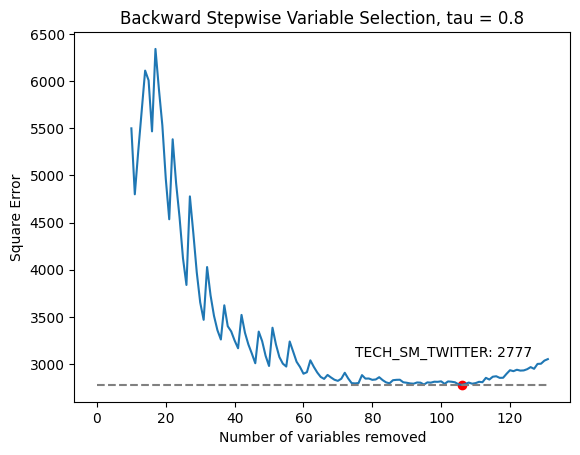

In [27]:
from matplotlib import pyplot as plt


plt.plot([131-n for n in range(len(removal_dict))], removal_dict.values())
min_value_col, min_value = sorted(removal_dict.items(), key=lambda item: item[1])[0]
plt.hlines(y = min_value, xmin=0, xmax=131, linestyles='--', colors='grey')
plt.annotate(f"{min_value_col}: {min_value}", (75, min_value+300))
plt.scatter(x = 106, y = min_value, c='r')
plt.xlabel("Number of variables removed")
plt.ylabel("Square Error")
plt.title("Backward Stepwise Variable Selection, tau = 0.8");

In [28]:

cosine_sim_7 = simnet.similarity.CosineSimilarity(0.7)

removal_dict_7:dict[str, int] = {}
logging_7:list[dict[str, int]] = []
cols_to_include_for_removal = cols_to_include.copy()

while (n:=len(cols_to_include_for_removal) )>=10:
    diff_dict = dict()
    for cat_col_i, col_name in enumerate(cols_to_include_for_removal):

        col_to_try = cols_to_include_for_removal[:cat_col_i] + cols_to_include_for_removal[cat_col_i+1:]
        sn = simnet.similarity.SimilarityNetwork(
            df,
            cosine_sim_7,
            col_to_try
        )
        W = sn.fit_transform().toarray()
        # G = sn.network.subgraph(dynamic.index)

        # W = np.matrix(nx.adjacency_matrix(G, dynamic.index).toarray())
        diff = get_diffusion_diff(
            np.matrix(W),
            dynamic.to_numpy(dtype=int),
            0.5
        )

        diff_dict[col_name] = diff

    rank_by_se = dict(sorted(diff_dict.items(), key=lambda item: item[1]))
    worst_col =  list(rank_by_se.keys())[0] ## Remove this columns yields the best performance improve
    logging_7.append(rank_by_se)
    removal_dict_7[worst_col] = rank_by_se[worst_col]
    print(n, worst_col, rank_by_se[worst_col], sep='\t')
    cols_to_include_for_removal.remove(worst_col)

131	EQ_REV_ON_PRIM	5316
130	TECH_FILE_PRTORD	5234
129	TECH_IFC_GISMAP	4996
128	TECH_TYP_TRACE	5031
127	CP_PSP_LEA	5084
126	POL_HOMELESS	4977
125	TECH_COMP_CRMANL	4780
124	EQ_SEATBELT	4889
123	POL_INV_INJRY	4821
122	EQ_SEC_FULLAUTO	4778
121	TECH_FILE_VIDEO	4809
120	ISSU_ADDR_DUI	4799
119	PERS_COLBAR_NON	4778
118	CP_SURV_POLICY	4778
117	TECH_ILES_INTEL	4794
116	EQ_AUTH_NECK	4724
115	log_budget	4718
114	TECH_TYP_TIREDFL	4720
113	EQ_SEMI_ON_BACK	4632
112	TECH_COMP_SNA	4604
111	ISSU_ADDR_HUMTRF	4691
110	EQ_BCK_IND	4695
109	EQ_SEC_SEMIAUTO	4720
108	TECH_WEB_STOP	4724
107	CP_SURV_TRAINING	4597
106	EQ_SEC_MANUAL	4690
105	EQ_AUTH_BLNT	4545
104	PERS_CREDHIS	4561
103	EQ_AUTH_EXP	4581
102	ISSU_ADDR_CYBER	4579
101	TECH_IFC_WARR	4554
100	TECH_WEB_COMPL	4520
99	CP_MISSION	4513
98	EQ_SEC_SHOTGUN	4539
97	EQ_BDYARM	4506
96	TECH_IFC_PRTORD	4513
95	EQ_DOC_EXP	4368
94	ISSU_ADDR_MISCHD	4432
93	EQ_AUTH_CED	4500
92	TECH_FILE_INFORM	4519
91	ISSU_ADDR_DRUG_ED	4454
90	CP_SURV_PERFORM	4465
89	POL_VEHPURS	4443
88	

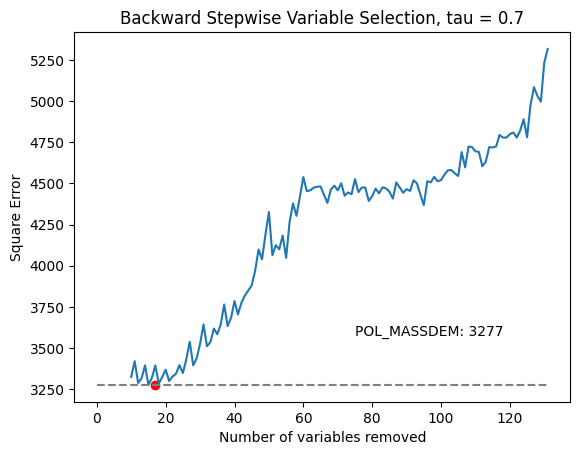

In [30]:
from matplotlib import pyplot as plt


plt.plot([131-n for n in range(len(removal_dict_7))], removal_dict_7.values())
min_value_col, min_value = sorted(removal_dict_7.items(), key=lambda item: item[1])[0]
plt.hlines(y = min_value, xmin=0, xmax=131, linestyles='--', colors='grey')
plt.annotate(f"{min_value_col}: {min_value}", (75, min_value+300))
plt.scatter(x = 17, y = min_value, c='r')
plt.xlabel("Number of variables removed")
plt.ylabel("Square Error")
plt.title("Backward Stepwise Variable Selection, tau = 0.7");

In [19]:
## try GA

## Try using genetic algorithm
def fitness_function(sim:simnet.similarity.CosineSimilarity):
    def f(ga_instance, solution, sol_index):

        # solution is a n = 131 vector, indicating include or not

        col_to_try = [cols_to_include[i] for i in range(len(solution)) if solution[i] == 1]
        sn = simnet.similarity.SimilarityNetwork(
            df,
            sim,
            col_to_try
        )
        W = sn.fit_transform().toarray()
        # G = sn.network.subgraph(dynamic.index)

        # W = np.matrix(nx.adjacency_matrix(G, dynamic.index).toarray())
        diff = get_diffusion_diff(
            np.matrix(W),
            dynamic.to_numpy(dtype=int),
            0.5
        )
        return 1/diff
    return f

In [20]:
import pygad

ga_instance_8 = pygad.GA(
    num_generations=100,
    num_parents_mating=4,
    fitness_func=fitness_function(cosine_sim_8),
    sol_per_pop = 64,
    num_genes=len(cols_to_include),
    mutation_percent_genes = 10,
    gene_space=[0,1],
    gene_type=int
)

ga_instance_7 = pygad.GA(
    num_generations=100,
    num_parents_mating=4,
    fitness_func=fitness_function(cosine_sim_7),
    sol_per_pop = 64,
    num_genes=len(cols_to_include),
    mutation_percent_genes = 10,
    gene_space=[0,1],
    gene_type=int
)

In [21]:
ga_instance_7.run()

In [22]:
solution, solution_fitness, solution_idx = ga_instance_7.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))


Parameters of the best solution : [1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0
 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
Fitness value of the best solution = 3503.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


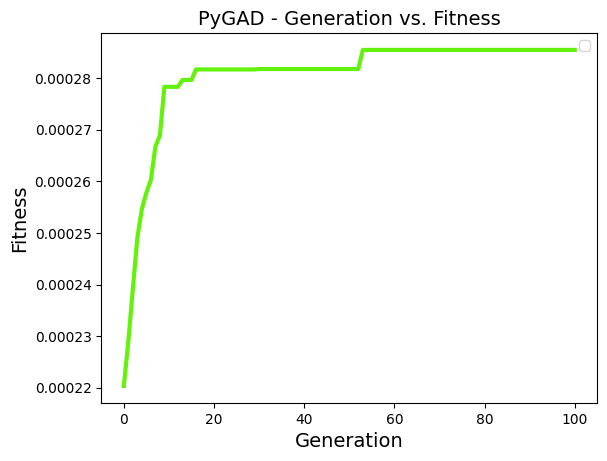

In [25]:
ga_instance_7.plot_fitness();

In [20]:
ga_instance_8.run()

In [61]:
solution, solution_fitness, solution_idx = ga_instance_8.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))


Parameters of the best solution : [0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0
 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0
 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0]
Fitness value of the best solution = 0.0003562522265764161


In [62]:
1/fitness_function(0,solution, 0)

2807.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


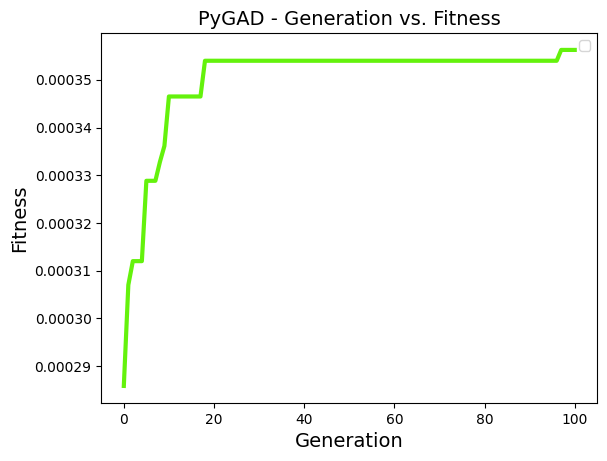

In [64]:
ga_instance_8.plot_fitness();

In [74]:
cols_to_include_for_removal = cols_to_include.copy()
solution_set = [1]*131
populations = []
for diff_dict in logging_8:
    rank_by_se = dict(sorted(diff_dict.items(), key=lambda item: item[1]))
    worst_col =  list(rank_by_se.keys())[0] ## Add this columns yields the best performance improve
    to_remove_index = cols_to_include.index(worst_col)
    solution_set[to_remove_index] = 0
    populations.append(solution_set.copy())

# get 10 min


In [99]:
init_population = np.array(populations[:131-60])
print(init_population.shape)

ga_instance_from_stepwise = pygad.GA(
    num_generations=60,
    num_parents_mating=4,
    fitness_func=fitness_function,
    initial_population=init_population,
    mutation_percent_genes = 10,
    gene_space=[0,1],
    gene_type=int
)

(71, 131)


In [100]:
ga_instance_from_stepwise.run()

In [102]:

solution, solution_fitness, solution_idx = ga_instance_from_stepwise.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=int(1/solution_fitness)))


Parameters of the best solution : [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1
 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0
 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1]
Fitness value of the best solution = 2777


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


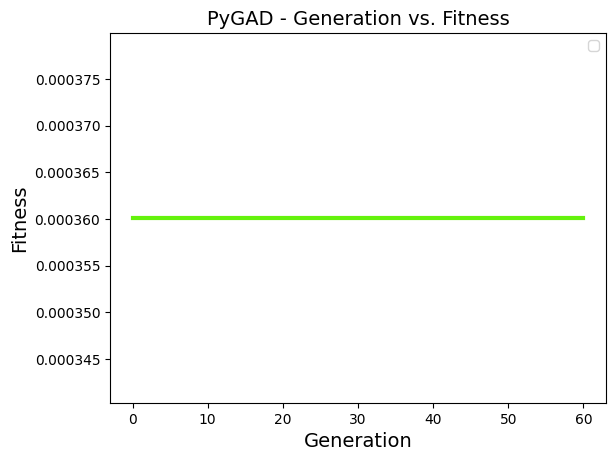

In [103]:
ga_instance_from_stepwise.plot_fitness();

In [104]:
with open("ga_step.pk", 'wb') as f:
    pickle.dump(ga_instance_from_stepwise, f)

## Try different cosine similarities

In [16]:
backward_different_cosine:dict[float, BackwardStepwise] = dict()

In [18]:

for cosine_threshold in np.arange(0.6,0.9,0.05):
    print("Processing:", cosine_threshold)
    cosine_sim = simnet.similarity.CosineSimilarity(cosine_threshold)
    bs = BackwardStepwise(
        traits_df=df,
        dynamic_df=dynamic,
        var_pool=cols_to_include,
        similarity_metric=cosine_sim,
        num_var_remain=10
    )

    bs.run()
    backward_different_cosine[cosine_threshold] = bs


Processing: 0.6
131	ISSU_ADDR_REPOFF	3707
130	POL_MAXHRS	3693
129	ISSU_ADDR_CP	3670
128	log_pop	3650
127	ISSU_ADDR_CRMPREV	3654
126	CP_PSP_ADVGRP	3635
125	PERS_EDU_MIN	3619
124	log_budget	3608
123	ISSU_ADDR_BOMB	3633
122	CP_PLAN	3603
121	TECH_WEB_COMPL	3594
120	EQ_REV_ON_BACK	3587
119	TECH_IFC_WARR	3566
118	ISSU_ADDR_RESRCH	3565
117	TECH_WEB_STOP	3551
116	TECH_TYP_TRACE	3536
115	ISSU_ADDR_SCH	3541
114	TECH_IFC_ADDHIS	3521
113	ISSU_ADDR_DRUG_ED	3519
112	CP_TRN_NEW	3511
111	TECH_FILE_GANG	3501
110	TECH_TYP_LPR	3499
109	TECH_IFC_DRVREC	3493
108	POL_VEHPURS	3479
107	EQ_SEC_MANUAL	3467
106	EQ_SEC_SEMIAUTO	3464
105	EQ_AUTH_BLNT	3470
104	TECH_FILE_PRTORD	3454
103	TECH_COMP_SNA	3459
102	POL_FOOT	3444
101	ISSU_ADDR_MISCHD	3444
100	EQ_UNI_CASH	3429
99	TECH_ILES_INTEL	3422
98	TECH_CIR	3415
97	ISSU_ADDR_DUI	3403
96	TECH_WEB_STAT	3394
95	ISSU_ADDR_SWAT	3395
94	ISSU_ADDR_DOM	3381
93	CP_MISSION	3372
92	OPER_MOTOPAT	3369
91	CP_SURV_RESOURCE	3378
90	EQ_REV_ON_PRIM	3376
89	OPER_BIKEPAT	3372
88	OPER_FOOT

In [21]:
backward_different_cosine

{0.6: <model_selection.stepwise.BackwardStepwise at 0x1e165f611d0>,
 0.65: <model_selection.stepwise.BackwardStepwise at 0x1e165f5af10>,
 0.7000000000000001: <model_selection.stepwise.BackwardStepwise at 0x1e151a17d10>,
 0.7500000000000001: <model_selection.stepwise.BackwardStepwise at 0x1e1519b7190>,
 0.8000000000000002: <model_selection.stepwise.BackwardStepwise at 0x1e165f72010>,
 0.8500000000000002: <model_selection.stepwise.BackwardStepwise at 0x1e1549cb5d0>,
 0.9000000000000002: <model_selection.stepwise.BackwardStepwise at 0x1e152ee9d10>}

In [35]:
import pickle

with open("bs_all.pk", "wb") as f:
    pickle.dump(
        {round(i, 2): v.logging for i,v in backward_different_cosine.items()}
        , f)

In [34]:
{round(i,2): v.logging for i,v in backward_different_cosine.items()}.keys()

dict_keys([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])

## Examine differnt cosine sim result

In [26]:
import pickle

with open("bs_all.pk", 'rb') as f:
    bs_all = pickle.load(f)

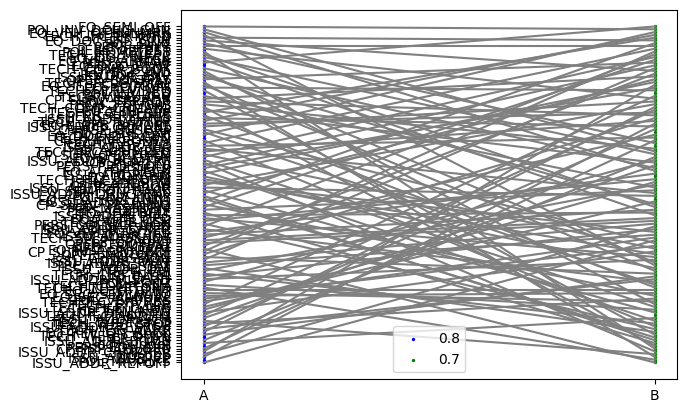

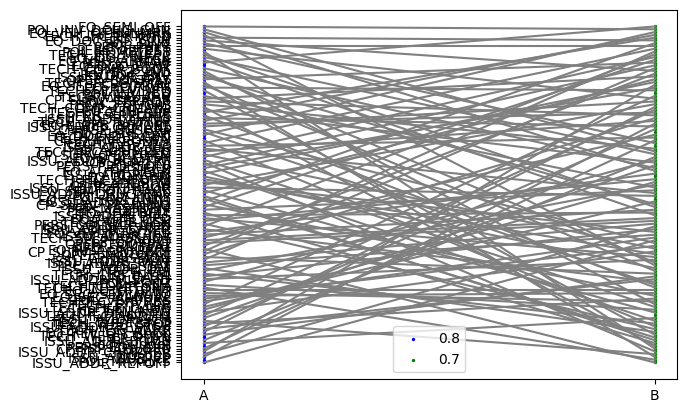

In [30]:
from model_selection.stepwise import StepwiseExaminer

bs_06 =  StepwiseExaminer(bs_all[0.6])
bs_07 = StepwiseExaminer(bs_all[0.7])

bs_06.compare_order_with(bs_07)

In [41]:
np.array( StepwiseExaminer(bs_all[0.7]).get_optimal_cols_set(2) )

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

## Optimal diffusion threshold?

When threshold of cosine similarity is 0.8, the p-value obtained from random rewiring is less than 0.05 only when the diffusion threshold is less than 0.4.

In [24]:
from functools import partial

bs_opt = BackwardStepwise(
        traits_df=df,
        dynamic_df=dynamic,
        var_pool=cols_to_include,
        similarity_metric=cosine_sim_8,
        num_var_remain=10
    )

pvals = bs_opt.get_origin_p_value()
list(enumerate(pvals))

100%|██████████| 9/9 [01:02<00:00,  6.93s/it]


[(0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (7, 0.0),
 (8, 0.0)]

In [23]:

bs_opt_7 = BackwardStepwise(
        traits_df=df,
        dynamic_df=dynamic,
        var_pool=cols_to_include,
        similarity_metric=cosine_sim_7,
        num_var_remain=10
    )

# try getting optimal p
pvals = bs_opt_7.get_origin_p_value(20)
list(enumerate(pvals))


100%|██████████| 19/19 [12:10<00:00, 38.47s/it]


[(0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (7, 0.0),
 (8, 1.0),
 (9, 1.0),
 (10, 1.0),
 (11, 1.0),
 (12, 1.0),
 (13, 1.0),
 (14, 1.0),
 (15, 1.0),
 (16, 1.0),
 (17, 1.0),
 (18, 1.0)]

for cosine threshold = 0.7, the optimal diffusion threshold is 8/20 = 0.4
for cosine threshold = 0.8, all diffusion threshold yields 0.0


In [7]:
from functools import partial

bs_opt_7 = BackwardStepwise(
        traits_df=df,
        dynamic_df=dynamic,
        var_pool=cols_to_include,
        similarity_metric=cosine_sim_7,
        num_var_remain=10
    )

optimal_diffusion_fn = partial(get_diffusion_diff, th=0.4)
bs_opt_7.set_diffusion_diff_function(optimal_diffusion_fn)

bs_opt_7.run(parallel=True)


131	TECH_IFC_WARR	8616
130	EQ_REV_ON_PRIM	8567
129	ISSU_ADDR_JUV	8236
128	EQ_SEC_MANUAL	8198
127	PERS_PHYS	8183
126	TECH_WEB_ASK	8025
125	EQ_UNI_CASH	8059
124	EQ_SEATBELT	7928
123	TECH_WEB_STOP	7834
122	log_budget	7900
121	ISSU_ADDR_MISCHD	8004
120	ISSU_ADDR_RESRCH	7824
119	EQ_VEH_OTHUNMRK	7802
118	log_pop	7839
117	ISSU_ADDR_ENV	7792
116	CP_PSP_LEA	7772
115	EQ_SEC_SEMIAUTO	7766
114	TECH_FILE_VIDEO	7768
113	TECH_IFC_ADDHIS	7547
112	TECH_COMP_CRMANL	7546
111	EQ_DOC_CHEM	7516
110	ISSU_ADDR_HUMTRF	7551
109	CP_SURV_TRAINING	7470
108	TECH_IFC_DRVREC	7489
107	ISSU_ADDR_BIAS	7361
106	OPER_MOTOPAT	7382
105	CP_SURV_PERFORM	7456
104	ISSU_ADDR_DRUG_ED	7349
103	POL_INV_ICD	7385
102	TECH_IFC_PRTORD	7394
101	OPER_FOOTPAT	7250
100	EQ_REV_OFF	7232
99	CP_TECH	7302
98	POL_INV_INJRY	7359
97	EQ_DOC_NECK	7057
96	CP_SURV_RESOURCE	7125
95	PERS_CREDHIS	7185
94	CP_TRN_NEW	7049
93	EQ_AUTH_EXP	7053
92	CP_SURV_CRPROB	7103
91	ISSU_ADDR_SCH	6938
90	TECH_FILE_PRTORD	6939
89	EQ_SEC_FULLAUTO	6952
88	TECH_IFC_MVREC	7042

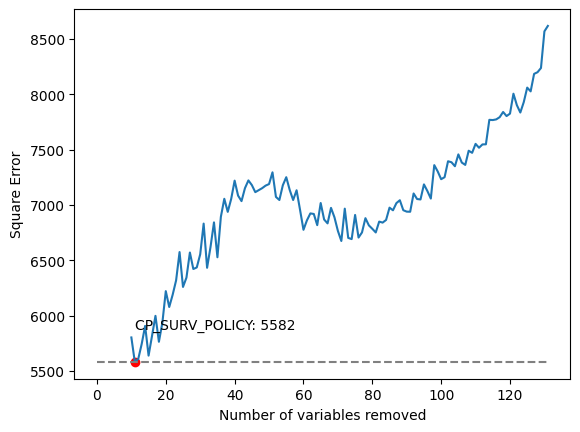

In [9]:
bs_opt_7.get_examiner().plot_score_evolution();

In [10]:
import pickle
with open("bs_opt.pk", 'wb') as f:
    pickle.dump(bs_opt, f)

In [11]:
bs_opt

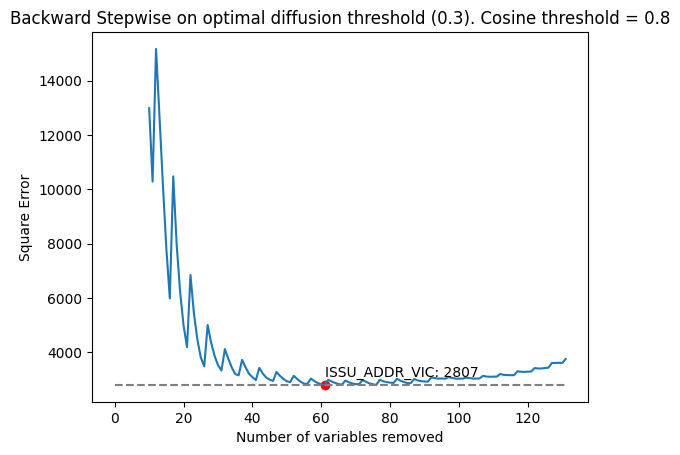

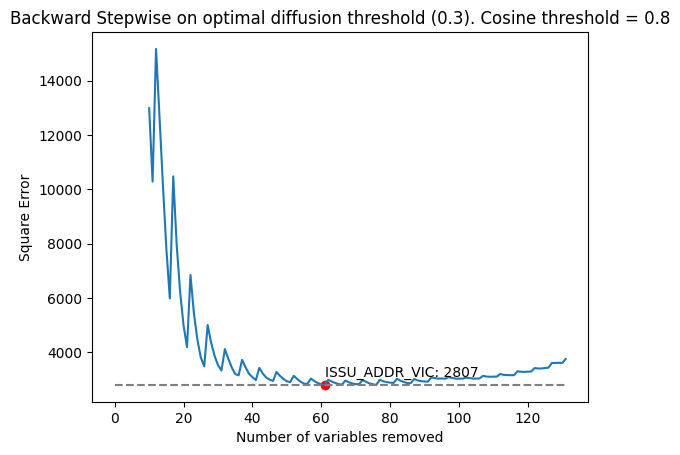

In [59]:
bs_opt.get_examiner().plot_score_evolution(title="Backward Stepwise on optimal diffusion threshold (0.3). Cosine threshold = 0.8")

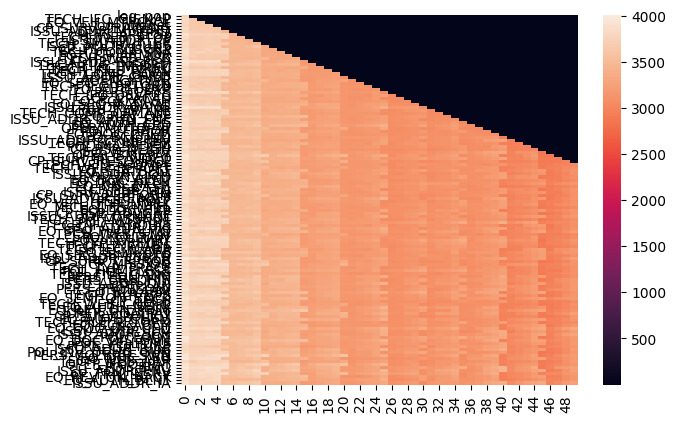

In [15]:
bs_opt.get_examiner().plot_heatmap(50);

## GA after optimal?

In [56]:

init_population = np.array(
bs_opt.get_examiner().get_optimal_cols_set(orig_cols=cols_to_include, n = 30)
)

ga_instance_from_stepwise = pygad.GA(
    num_generations=100,
    num_parents_mating=4,
    fitness_func=fitness_function(cosine_sim_8),
    initial_population=init_population,
    mutation_percent_genes = 10,
    gene_space=[0,1],
    gene_type=int
)

In [57]:
ga_instance_from_stepwise.run()

In [62]:
def show_ga_performance(ga: pygad.GA):
    solution, solution_fitness, solution_idx = ga.best_solution()
    print("Parameters of the best solution : {solution}".format(solution=solution))
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))
    ga.plot_fitness();


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Parameters of the best solution : [1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0
 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0]
Fitness value of the best solution = 2708.0


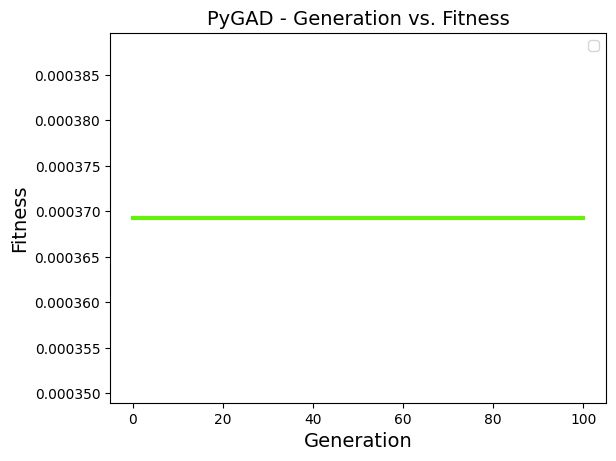

In [63]:
show_ga_performance(ga_instance_from_stepwise)

## GA on cosine_sim_07

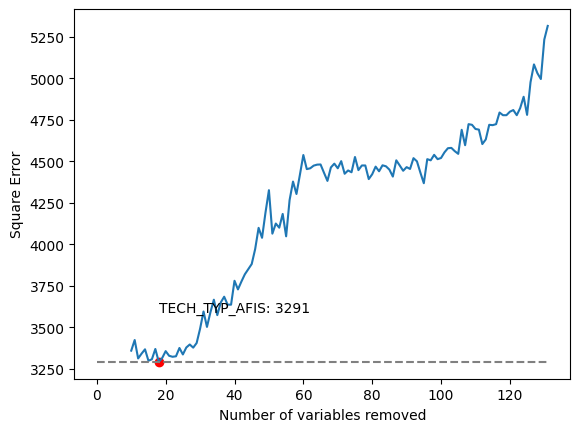

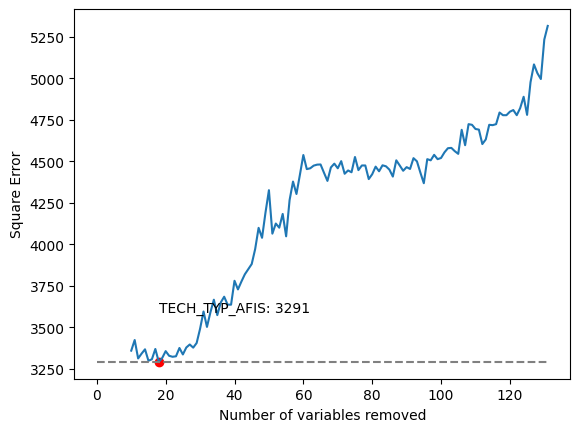

In [68]:
StepwiseExaminer(bs_all[0.7]).plot_score_evolution()

In [69]:

init_population = np.array(
StepwiseExaminer(bs_all[0.7]).get_optimal_cols_set(orig_cols=cols_to_include, n = 30)
)

ga_instance_from_stepwise_7 = pygad.GA(
    num_generations=100,
    num_parents_mating=4,
    fitness_func=fitness_function(cosine_sim_7),
    initial_population=init_population,
    mutation_percent_genes = 20,
    gene_space=[0,1],
    gene_type=int
)

In [70]:
ga_instance_from_stepwise_7.run()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Parameters of the best solution : [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Fitness value of the best solution = 3291.0000000000005


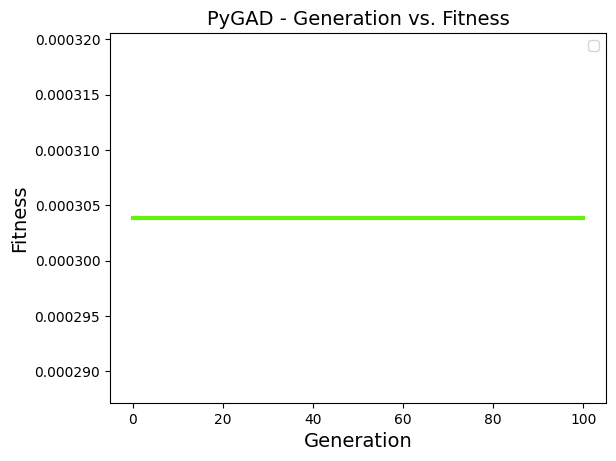

In [71]:
show_ga_performance(ga_instance_from_stepwise_7)

first GA, then greedy

1. Stepwise result
2. Cosine threshold = 0.9 performs best?
2. GA


benchmark: no dif/no sim network

vs

have some th, see improvement

## Improvement from adding threshold

In [7]:
from dotomorrow import SavedIterator

diffusion_threshold_space = range(1,10)

with SavedIterator('diff_th', diffusion_threshold_space) as si:
    for diff_th in tqdm(si):

        bs= BackwardStepwise(
                traits_df=df,
                dynamic_df=dynamic,
                var_pool=cols_to_include,
                similarity_metric=cosine_sim_7,
                num_var_remain=10
            )

        optimal_diffusion_fn = partial(get_diffusion_diff, th = 0.1 * diff_th)
        bs.set_diffusion_diff_function(optimal_diffusion_fn)
        bs.run(parallel=True)

        si += bs

Cache found in diff_th. 0 iterations remained.


0it [00:00, ?it/s]


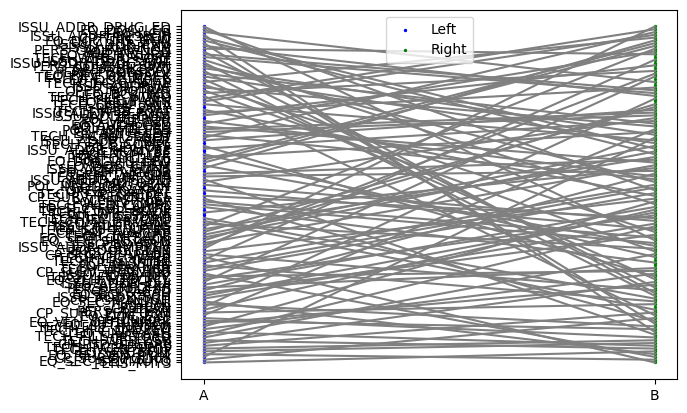

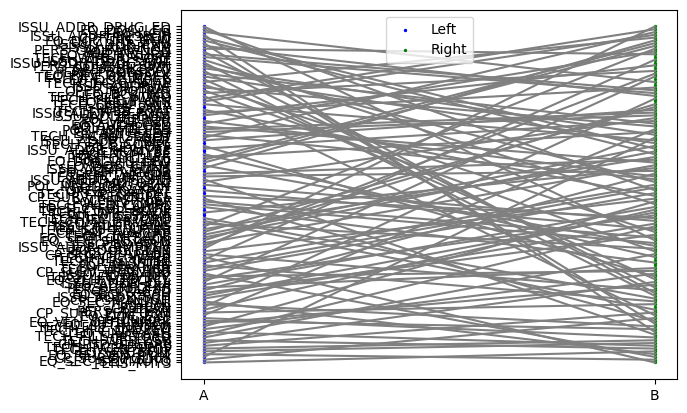

In [13]:
from model_selection.stepwise import StepwiseExaminer
th_3: StepwiseExaminer = si.results[3].get_examiner()
th_4: StepwiseExaminer = si.results[4].get_examiner()
th_5: StepwiseExaminer = si.results[5].get_examiner()

th_3.compare_order_with(th_4)

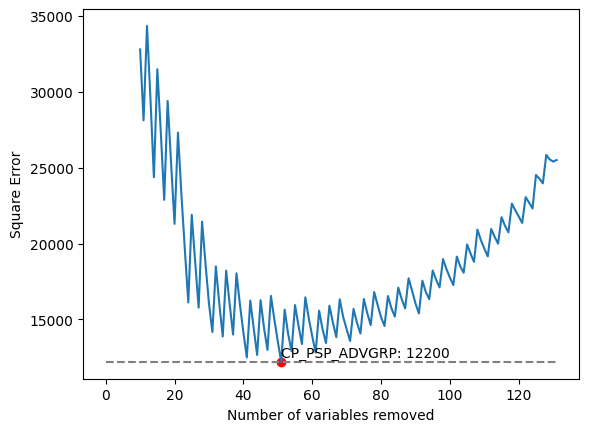

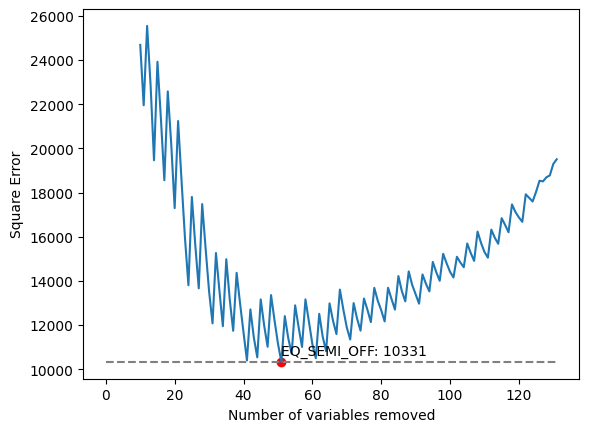

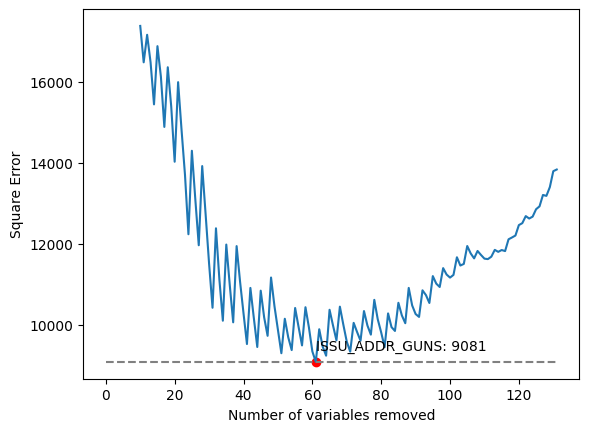

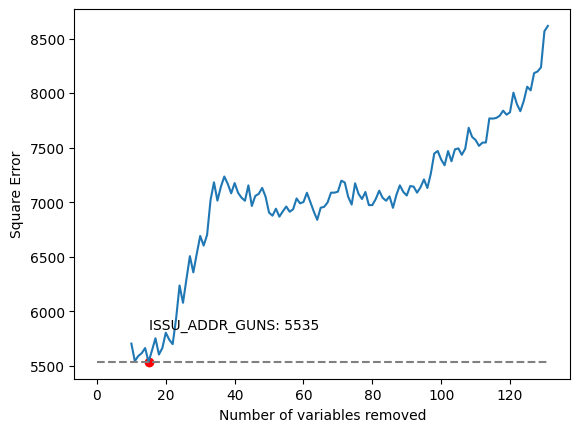

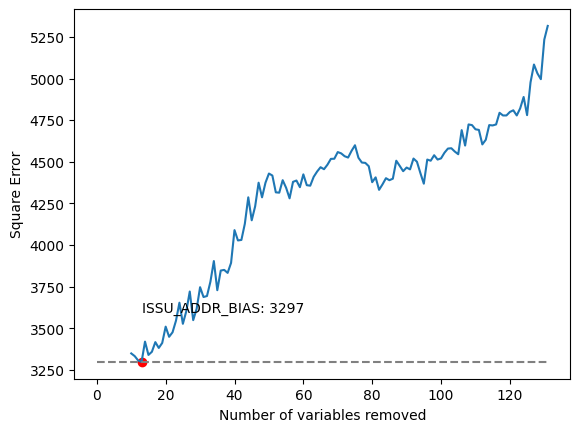

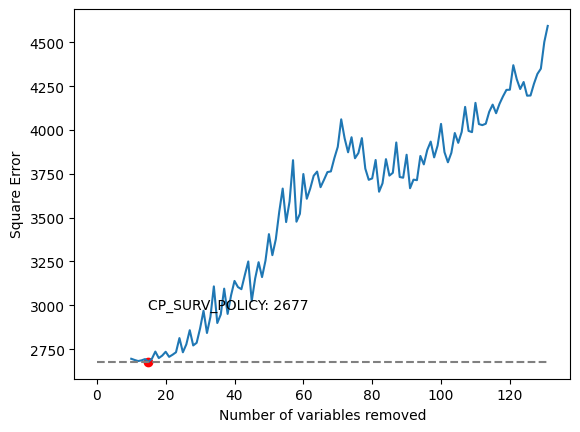

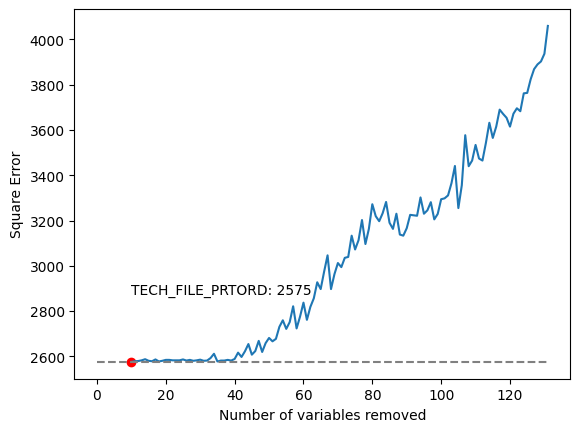

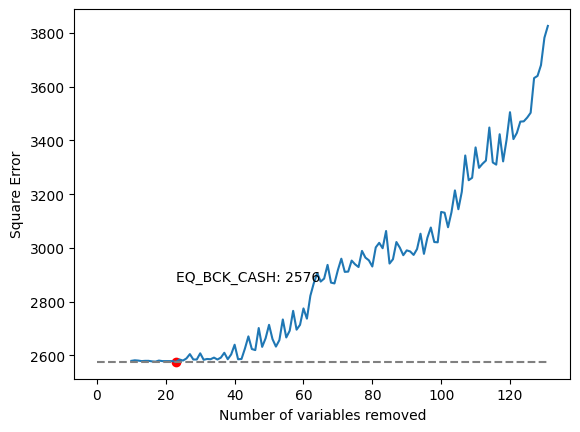

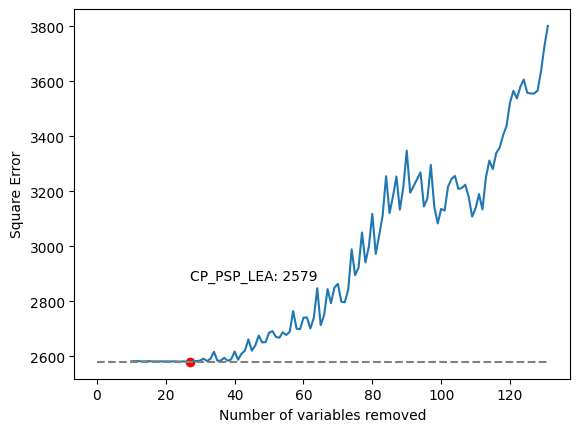

In [15]:
for bsm in si.results.values():
    bsm: BackwardStepwise
    bsm.get_examiner().plot_score_evolution()

# Examine between cosine threshold=0.7~0.8, under 0.5 diffusion rate, and observe the survival rate of each variables

In [11]:
import numpy as np
import pandas as pd
from dotomorrow import SavedIterator


cosine_param_space = np.linspace(0.7, 0.8, 11)

In [ ]:

with SavedIterator('within_7_8', cosine_param_space) as si:
    for cosine_threshold in si:
        print("Processing:", cosine_threshold)
        cosine_sim = simnet.similarity.CosineSimilarity(cosine_threshold)
        bs = BackwardStepwise(
            traits_df=df,
            dynamic_df=dynamic,
            var_pool=cols_to_include,
            similarity_metric=cosine_sim,
            num_var_remain=10
        )
        bs.run(parallel=True)

        si+=bs

In [8]:
import pickle

# with open('witin_78.pk', 'wb') as f:
#     to_dump = {k:v.get_examiner() for k,v in si.results.items()}
#     pickle.dump(to_dump, f)

with open('witin_78.pk', 'rb') as f:
    to_dump = pickle.load(f)

In [19]:
test_bwe = to_dump[0.75]

test_bwe.get_removal_dict()

{'ISSU_ADDR_CRMPREV': 4414,
 'ISSU_ADDR_MISCHD': 4377,
 'CP_PLAN': 4323,
 'PERS_CULTURE': 4284,
 'EQ_SEC_SEMIAUTO': 4268,
 'ISSU_ADDR_CRMANL': 4158,
 'EQ_DOC_BLNT': 4062,
 'EQ_DOC_NECK': 4048,
 'TECH_TYP_LPR': 4071,
 'TECH_IFC_WARR': 4012,
 'ISSU_ADDR_RESRCH': 3998,
 'CP_SURV_POLICY': 4042,
 'TECH_WEB_COMPL': 4087,
 'ISSU_ADDR_GUNS': 4046,
 'POL_VEHPURS': 4015,
 'ISSU_ADDR_DRUG_ENF': 4067,
 'EQ_REV_ON_PRIM': 3946,
 'EQ_AUTH_LEG': 4034,
 'CP_SURV_TRAINING': 3992,
 'CP_CPACAD': 4079,
 'EQ_SEMI_ON_BACK': 4069,
 'ISSU_ADDR_JUV': 4084,
 'CP_SURV_PERFORM': 4032,
 'CP_MISSION': 3990,
 'TECH_IFC_MVREC': 4026,
 'CP_PSP_ADVGRP': 3929,
 'EQ_SEC_FULLAUTO': 3966,
 'log_pop': 4112,
 'EQ_AUTH_EXP': 4143,
 'ISSU_ADDR_BIAS': 4037,
 'TECH_IFC_DRVREC': 3973,
 'ISSU_ADDR_ENV': 3961,
 'TECH_IFC_ADDHIS': 3879,
 'EQ_DOC_EXP': 3828,
 'CP_PSP_NEIGH': 3903,
 'EQ_REV_ON_BACK': 3900,
 'TECH_WEB_STOP': 3913,
 'TECH_COMP_BOOK': 3813,
 'CP_PSP_BUSGRP': 3852,
 'POL_MAXHRS': 3885,
 'EQ_SEATBELT': 3905,
 'EQ_UNI_CASH':

In [9]:
from model_selection.stepwise import varibale_survival_analysis

var_counter = varibale_survival_analysis(to_dump, 0.5)
var_counter.most_common()

[('POL_INV_DCHG_GUN', 11),
 ('CP_TRN_INSRV', 11),
 ('PERS_POLY', 10),
 ('EQ_DOC_DIS_CED', 10),
 ('ISSU_ADDR_VIC', 10),
 ('CP_TRN_NEW', 10),
 ('ISSU_ADDR_TERROR', 10),
 ('PERS_COLBAR_NON', 10),
 ('ISSU_ADDR_IA', 10),
 ('EQ_BCK_AGCY', 9),
 ('POL_CULTAW', 9),
 ('TECH_TYP_GPS', 9),
 ('OPER_BIKEPAT', 9),
 ('PERS_COLBAR_SWN', 9),
 ('TECH_FILE_PAWN', 9),
 ('TECH_CIR', 9),
 ('ISSU_ADDR_GANG', 9),
 ('ISSU_ADDR_RESRCH', 9),
 ('TECH_FILE_VIDEO', 9),
 ('EQ_VEH_ATV', 8),
 ('POL_BWC', 8),
 ('ISSU_ADDR_CRMANL', 8),
 ('ISSU_ADDR_FIN', 8),
 ('ISSU_ADDR_CHILD', 8),
 ('TECH_WEB_REPORT', 8),
 ('TECH_IFC_CRIMREC', 8),
 ('PERS_APTEST', 8),
 ('PERS_PHYS', 8),
 ('PERS_PROBSOLV', 8),
 ('ISSU_ADDR_SWAT', 8),
 ('POL_HOMELESS', 8),
 ('TECH_COMP_SNA', 8),
 ('EQ_REV_ON_BACK', 7),
 ('ISSU_ADDR_DRUG_ENF', 7),
 ('EQ_DOC_DIS_GUN', 7),
 ('ISSU_ADDR_CP', 7),
 ('CP_PSP_ADVGRP', 7),
 ('ISSU_ADDR_BOMB', 7),
 ('TECH_TYP_AFIS', 7),
 ('TECH_WEB_ARR', 7),
 ('ISSU_ADDR_DUI', 7),
 ('EQ_AUTH_BLNT', 7),
 ('EQ_BCK_IND', 7),
 ('TECH_

Text(0.5, 0, 'Number a variable survived during the first half of stepwise elimination')

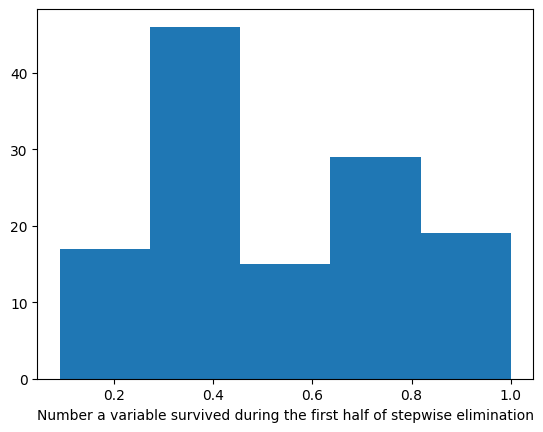

In [25]:
plt.hist([e[1]/len(to_dump) for e in var_counter.most_common()], bins=5)
plt.xlabel("Number a variable survived during the first half of stepwise elimination")

# Descriptive Analysis for a given column

Given a variable and a name, separated by NIBRS adoption indicies, observe the correlation

In [139]:
def descriptive(col_name:str, year:int, ax:plt.Axes):
    import seaborn as sns
    from scipy.stats import chi2

    var_data = df[[col_name]]
    dy = dynamic[[year]]

    combined = var_data.join(dy)
    combined.columns = [col_name, 'Using NIBRS']
    # print(combined)

    sns.countplot(combined, hue=col_name, x='Using NIBRS', ax=ax, stat='percent')

    # Chi2 test
    pv = combined.reset_index().pivot_table(index = col_name, columns='Using NIBRS', values=col_name, aggfunc='count')
    pv.columns = ['F', 'T']
    pv['rF'] = pv['F'] / pv['F'].sum()
    pv['rT'] = pv['T'] / pv['T'].sum()
    pv['dif'] = (pv['rF'] - pv['rT'])**2 / pv['rF']

    chi2v = pv['dif'].sum()
    dof = len(pv) - 1
    critical_value = chi2.ppf(q = 1 - 0.05, df = dof)

    print(col_name)
    print(f"X2({dof}, 0.05) = {critical_value}")
    print(f"X2 = {chi2v}")
    print(f"p-value = {chi2.sf(chi2v, dof)}")
    print("Reject" if chi2v>critical_value else "No reject")
    print("="*30)


POL_INV_DCHG_GUN
X2(1, 0.05) = 3.841458820694124
X2 = 0.007754285739905742
p-value = 0.9298302421444602
No reject


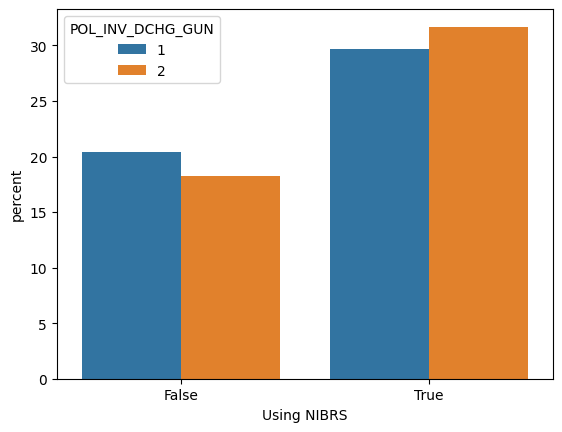

In [140]:
fig, ax = plt.subplots(1,1)
descriptive('POL_INV_DCHG_GUN', 2020, ax)

In [16]:
Nf = 50
top_N_feature = [f[0] for f in var_counter.most_common(Nf)]
top_N_feature

['POL_INV_DCHG_GUN',
 'CP_TRN_INSRV',
 'PERS_POLY',
 'EQ_DOC_DIS_CED',
 'ISSU_ADDR_VIC',
 'CP_TRN_NEW',
 'ISSU_ADDR_TERROR',
 'PERS_COLBAR_NON',
 'ISSU_ADDR_IA',
 'EQ_BCK_AGCY',
 'POL_CULTAW',
 'TECH_TYP_GPS',
 'OPER_BIKEPAT',
 'PERS_COLBAR_SWN',
 'TECH_FILE_PAWN',
 'TECH_CIR',
 'ISSU_ADDR_GANG',
 'ISSU_ADDR_RESRCH',
 'TECH_FILE_VIDEO',
 'EQ_VEH_ATV',
 'POL_BWC',
 'ISSU_ADDR_CRMANL',
 'ISSU_ADDR_FIN',
 'ISSU_ADDR_CHILD',
 'TECH_WEB_REPORT',
 'TECH_IFC_CRIMREC',
 'PERS_APTEST',
 'PERS_PHYS',
 'PERS_PROBSOLV',
 'ISSU_ADDR_SWAT',
 'POL_HOMELESS',
 'TECH_COMP_SNA',
 'EQ_REV_ON_BACK',
 'ISSU_ADDR_DRUG_ENF',
 'EQ_DOC_DIS_GUN',
 'ISSU_ADDR_CP',
 'CP_PSP_ADVGRP',
 'ISSU_ADDR_BOMB',
 'TECH_TYP_AFIS',
 'TECH_WEB_ARR',
 'ISSU_ADDR_DUI',
 'EQ_AUTH_BLNT',
 'EQ_BCK_IND',
 'TECH_TYP_TIREDFL',
 'ISSU_ADDR_CYBER',
 'TECH_WEB_COMPL',
 'TECH_FILE_PRTORD',
 'TECH_IFC_GISMAP',
 'TECH_FILE_COMPL',
 'OPER_BOATPAT']

POL_INV_DCHG_GUN
X2(1, 0.05) = 3.841458820694124
X2 = 2.867502070094945e-05
p-value = 0.9957274234162362
No reject
CP_TRN_INSRV
X2(2, 0.05) = 5.991464547107979
X2 = 0.013177022803700521
p-value = 0.9934331452515912
No reject
PERS_POLY
X2(1, 0.05) = 3.841458820694124
X2 = 0.0017113503654707426
p-value = 0.9670021480320486
No reject
EQ_DOC_DIS_CED
X2(3, 0.05) = 7.814727903251179
X2 = 0.016869910639155414
p-value = 0.9994201828099745
No reject
ISSU_ADDR_VIC
X2(4, 0.05) = 9.487729036781154
X2 = 0.0024711486277021167
p-value = 0.9999992373065268
No reject
CP_TRN_NEW
X2(3, 0.05) = 7.814727903251179
X2 = 0.0018105154059835885
p-value = 0.9999795220599668
No reject
ISSU_ADDR_TERROR
X2(4, 0.05) = 9.487729036781154
X2 = 0.024513103788052708
p-value = 0.9999254993950876
No reject
PERS_COLBAR_NON
X2(3, 0.05) = 7.814727903251179
X2 = 0.08187553612389528
p-value = 0.9939199437352433
No reject
ISSU_ADDR_IA
X2(4, 0.05) = 9.487729036781154
X2 = 0.019582520568586278
p-value = 0.999952377357216
No reject

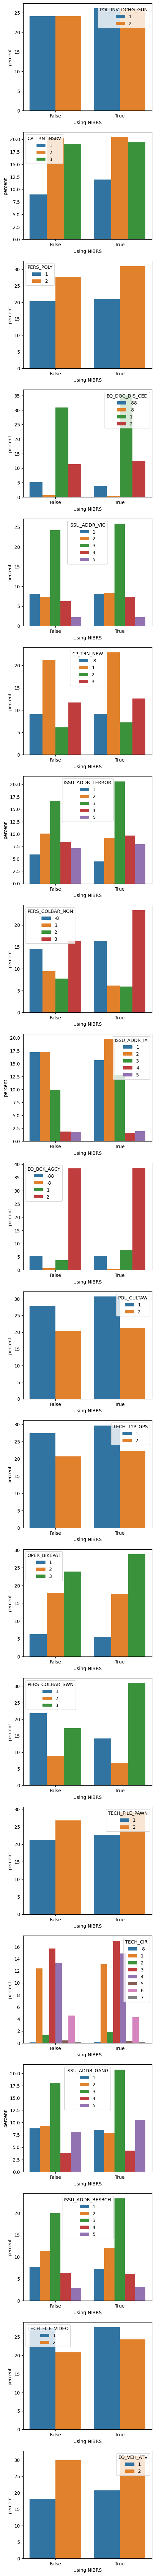

In [141]:
fig, axs = plt.subplots(Nf, 1, figsize=(5,5*Nf))
for i,f in enumerate(top_N_feature):
    descriptive(f, 2019, axs[i])

In [49]:
from simnet.similarity import SimilarityNetwork, DiffusionDifferent
from model_selection.stepwise import StepwiseExaminer

sn_top_N = SimilarityNetwork(
    df = df,
    similarity_measure= simnet.similarity.CosineSimilarity(0.7),
    match_columns=top_N_feature
)

W = sn_top_N.fit_transform()
dynamic_np = dynamic.to_numpy(dtype=np.float_)

get_diffusion_diff(W, dynamic_np, 0.5)

5406

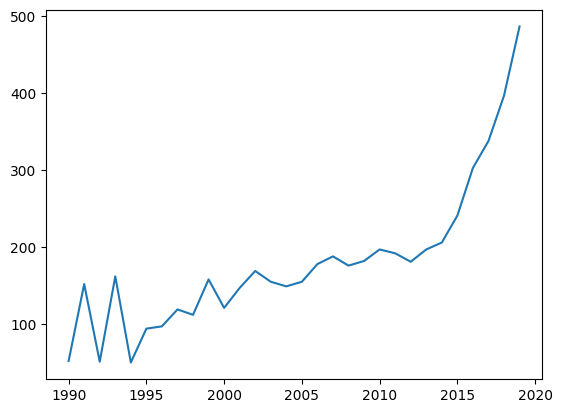

In [32]:
dd = DiffusionDifferent(df, cosine_sim_7, dynamic, top_N_feature)
plt.plot(range(1990, 2020), dd.fit_diff())

In [52]:
def get_optimal_col_list(se: StepwiseExaminer):

    last_removes_col = list(
                dict(
                sorted(se.removal_dict.items(), key= lambda item: item[1])
                ).keys())[0]   # remove up to this

    remain_list = se.score_evolution(True)[1]

    iteration_when_removed = remain_list.index(last_removes_col)
    unremoved = remain_list[iteration_when_removed:]
    return unremoved

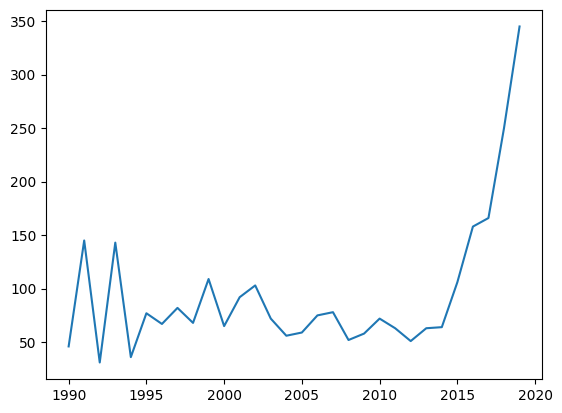

In [55]:
# diffusion different dynamic for cosine=0.7 and 0.8
th_cos = 0.8
sn:StepwiseExaminer = to_dump[th_cos]

unremoved = get_optimal_col_list(sn)
# sn.plot_score_evolution();

dd = DiffusionDifferent(df, simnet.similarity.CosineSimilarity(th_cos), dynamic, unremoved)
plt.plot(range(1990, 2020), dd.fit_diff());